## Health Verity Analysis
## Jasmine Haltam

1. This analysis leveraged GCP Cloud Storage/BigQuery, GCP Vertex AI, Python, and SQL. 

2. The initial Sample_Claims dataset was loaded to BigQuery with Schema matching the Table_Definitions guidelines, resulting in exclusion of 25 rows that did not meet the Schema. The final dataset was a matrix of 4,975 rows x 6 cols.

**Question 1**

**1a. What are the top 5 most common valid procedure codes?**

**1a. 88175, 87591, 87491, 87798, 85049.**

In [1]:
%%bigquery

#Code for Question 1. Subquery sorts by most prevalent procedure code descending (Top 5). Returns only distinct procedure code

SELECT DISTINCT procedure_code
FROM 
(select procedure_code, COUNT(procedure_code) as total
FROM `healthverityproject.sample_claims.notnull`
GROUP BY procedure_code
ORDER BY total DESC
LIMIT 5);

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.92rows/s]


,procedure_code
0,88175
1,87591
2,87491
3,87798
4,85049


**1b.How many patients are associated with at least one of those procedures?**

**1b. 58** unique patients are associated with at least one of the procedure codes above.

In [1]:
%%bigquery

#Query uses code above to return the distinct patients associated with top 5 procedures. 

SELECT COUNT (DISTINCT patient_id) as total_patients
FROM `healthverityproject.sample_claims.notnull`
WHERE procedure_code in (SELECT DISTINCT procedure_code
FROM 
(select procedure_code, COUNT(procedure_code) as total
FROM `healthverityproject.sample_claims.notnull`
GROUP BY procedure_code
ORDER BY total DESC
LIMIT 5))
ORDER BY total_patients DESC;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.13s/rows]


,total_patients
0,58


**1c. What is the percentage of records in sample_claims that have valid procedure codes?**

1c. We will define valid procedure codes as non-null procedure codes that successfully join the reference table. 

**1c. 66.4%** of records contain a valid procedure code.


In [18]:
%%bigquery

##Query divides the number of records successfully joining the cpt_codes table by the total number of rows.
SELECT (y.valid_codes/x.total_rows)*100 as PercentValid, Valid_Codes, Total_Rows
FROM
(SELECT COUNT(*) as Total_Rows
FROM `healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf`) x
JOIN
(SELECT COUNT(*) as valid_codes
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf master
 inner join healthverityproject.valid_cpt_codes.valid_cpt_codes cpt on cpt.code = master.procedure_code
WHERE master.procedure_code IS NOT NULL) y
on 1=1

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.08rows/s]


,PercentValid,Valid_Codes,Total_Rows
0,66.41206,3304,4975


**Question 2**

**2a)What are the top 5 most common valid diagnosis codes? Note: Diagnosis code field needs to be split.**

We will define valid diagnosis codes as the ICD10 codes that successfully join the reference ICD10 table. 

**2a) Z11, Z34, Z01, E55, Z12.**

In [27]:
%%bigquery
##First, we unnest diagnosis codes by '^' delimiter. 
##We use regex to split to the period to allow us to join to the reference ICD10 table. 
##Alternative solutions included potentially adding a period after the first 3 characters in the reference ICD10 table.  

CREATE TABLE healthverityproject.sampledataset5.extracted_icd as (
WITH data AS 
  (SELECT diagnosis_codes
  FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf)

SELECT diagnosis_codes, substrings, REGEXP_EXTRACT(substrings, r'^[^\.]+') as substrings_simplified
FROM data, UNNEST(SPLIT(diagnosis_codes, '^')) substrings)


Query complete after 0.01s: 100%|██████████| 3/3 [00:00<00:00, 1300.83query/s]                        


""


In [34]:
%%bigquery
##Return the top 5 most common valid ICD codes that match the icd_10_codes reference table after cleanup above. 

SELECT substrings_simplified, COUNT(substrings_simplified) as total ##return count of substrings grouped by substring. 
from healthverityproject.sampledataset5.extracted_icd as original
inner JOIN healthverityproject.icd10codes.icd_10_codes as n ##use inner join to filter unmatched values. 
ON original.substrings_simplified = n.string_field_0
where substrings_simplified is not null ##filter any null substrings_simplified_values
GROUP BY substrings_simplified
ORDER BY total DESC
LIMIT 5; ##limit to only the top 5 most frequent, valid diagnosis codes. 

Downloading: 100%|██████████| 5/5 [00:00<00:00,  5.17rows/s]


,substrings_simplified,total
0,Z11,1466
1,Z34,855
2,Z01,525
3,E55,494
4,Z12,427


**Question 2b. What are the top 5 invalid diagnosis codes? With and without special characters removed.**

**2b. With special character removed:** Z86, Z87, Z91. 

**2b. Without special character removed (after join):** Z86.718, Z87.59, Z87.898, Z87.440, Z91.89. 

**2b. Without special character removed (pre-join):** Z11.3, E55.9, Z01.419, Z11.8, Z34.81. 

In [37]:
%%bigquery
##With the special character "." removed, return the top invalid ICD10 codes that do not join the reference table. 

SELECT substrings_simplified, COUNT(substrings_simplified) as total ##return count of substrings grouped by simplified substring with special char removed. 
from healthverityproject.sampledataset5.extracted_icd as original
left JOIN healthverityproject.icd10codes.icd_10_codes as n ##use left join to return everything 
ON original.substrings_simplified = n.string_field_0
where string_field_0 is null ##filter to return only the invalid ICD10 values
GROUP BY substrings_simplified
ORDER BY total DESC
LIMIT 5;

Downloading: 100%|██████████| 3/3 [00:00<00:00,  3.16rows/s]


,substrings_simplified,total
0,Z86,32
1,Z87,23
2,Z91,1


In [45]:
%%bigquery
##Returning the invalid codes without their special character removed in the final output. 
#Note that to successfully join, the period needed to be removed pre-join.  

SELECT substrings, substrings_simplified, COUNT(substrings) as total ##return count of substrings grouped by substring. 
from healthverityproject.sampledataset5.extracted_icd as original
left JOIN healthverityproject.icd10codes.icd_10_codes as n ##use left join to return everything 
ON original.substrings_simplified = n.string_field_0
where string_field_0 is null ##filter to return only the invalid ICD10 values
GROUP BY substrings_simplified, substrings
ORDER BY total DESC
LIMIT 5;

Downloading: 100%|██████████| 5/5 [00:00<00:00,  5.39rows/s]


,substrings,substrings_simplified,total
0,Z86.718,Z86,32
1,Z87.59,Z87,17
2,Z87.898,Z87,5
3,Z91.89,Z91,1
4,Z87.440,Z87,1


In [44]:
%%bigquery
##Without the special character "." removed, return the top invalid ICD10 codes that do not join the reference table. 
##None of these codes should join, as the reference table does not contain periods in its values. 

SELECT substrings, substrings_simplified, COUNT(substrings) as total ##return count of substrings grouped by substring. 
from healthverityproject.sampledataset5.extracted_icd as original
left JOIN healthverityproject.icd10codes.icd_10_codes as n ##use left join to return everything 
ON original.substrings = n.string_field_0
where string_field_0 is null ##filter to return only the invalid ICD10 values
GROUP BY substrings_simplified, substrings
ORDER BY total DESC
LIMIT 5;

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.94rows/s]


,substrings,substrings_simplified,total
0,Z11.3,Z11,942
1,E55.9,E55,494
2,Z01.419,Z01,403
3,Z11.8,Z11,357
4,Z34.81,Z34,346


**Question 2c. What is the percentage of records in sample_claims that have valid  diagnosis codes after split and with special characters removed?**

Note that sample_claims, after splitting the diagnosis codes, has 10,064 rows. 

**2c. 99.4%, or 10,008 records with ICD codes,** successfully join the ICD10 reference table.

In [52]:
%%bigquery
SELECT (x.valid_codes/y.total_rows)*100 as PercentValid, Valid_Codes, Total_Rows
FROM
(SELECT COUNT(*) as Valid_Codes
FROM healthverityproject.sampledataset5.extracted_icd extracted
 inner JOIN healthverityproject.icd10codes.icd_10_codes as n ##use inner join to filter unmatched values. 
ON extracted.substrings_simplified = n.string_field_0
where substrings_simplified is not null) x ##added filter
JOIN
(select count(*) as total_rows from 
healthverityproject.sampledataset5.extracted_icd) y
on 1=1

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.02rows/s]


,PercentValid,Valid_Codes,Total_Rows
0,99.443561,10008,10064


**Question 3.**


Using the TableDefinitions provided and sample files, please write at least 1 data quality
validation for each category below. Minimum 5 and no more than 10 validations required.

**1.Formatting**

**2.Duplicates**

**3.Missing values**

**4.Referential**

**5.Date Distribution (trend in chronological order)**

**1. Formatting - Date Format Validation**

In [83]:
%%bigquery
WITH query_result AS (
SELECT * FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE PARSE_DATE('%Y-%d-%m', FORMAT_DATE('%Y-%d-%m', date_service)) IS NULL)
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: File fails date formatting.', 'Validation Pass: File passes date formatting validation.') as Validation_Message from query_result


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.09rows/s]


,Validation_Message
0,Validation Error: File fails date formatting.


**2. Duplicates - Overall Duplicate Entry Validation**

In [94]:
%%bigquery
WITH query_result AS (SELECT patient_id,claim_id,diagnosis_codes,procedure_code,date_service,date_received,count(*)
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
GROUP BY patient_id,claim_id,diagnosis_codes,procedure_code,date_service,date_received 
HAVING count(*) > 1)

SELECT 
 IF(COUNT(*) > 0, 'Validation Error: File contains duplicate rows.', 'Validation Pass: No duplicate rows.') as Validation_Message from query_result

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.01rows/s]


,Validation_Message
0,Validation Pass: No duplicate rows.


**Duplicates - Claim ID Validation**

In [96]:
%%bigquery
WITH query_result AS (WITH duplicate_rows AS (
  SELECT claim_id, 
    ROW_NUMBER() OVER (PARTITION BY claim_id ORDER BY claim_id) as row_number ##Ranks claim IDs. If duplicate, row_number > 1. 
  FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf)

SELECT claim_id
FROM duplicate_rows
WHERE row_number > 1) ##Filter to return duplicate claim ID values. 

SELECT  IF(COUNT(*) > 0, 'Validation Error: Duplicated Claim IDs.', 'Validation Pass: File has no duplicates.') as Validation_Message from query_result

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.05rows/s]


,Validation_Message
0,Validation Error: Duplicated Claim IDs.


**3.Missing values - ICD 10 Code Validation**

In [97]:
%%bigquery
WITH query_result AS (SELECT * 
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE diagnosis_codes IS NULL)
##Filter for null diagnosis codes, if > 0, return validation error. 
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: Missing ICD10 Codes.', 'Validation Pass: File has no missing values.') as Validation_Message from query_result


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.02s/rows]


,Validation_Message
0,Validation Error: Missing ICD10 Codes.


**Missing values - Patient ID Validation**

In [98]:
%%bigquery
WITH query_result AS (SELECT * 
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE patient_id IS NULL)
##Filter for null patient ID, if > 0, return validation error. 
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: Missing Patient IDs.', 'Validation Pass: File has no missing values.') as Validation_Message from query_result

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.06rows/s]


,Validation_Message
0,Validation Error: Missing Patient IDs.


**4.Referential - CPT Code Validation**

In [99]:
%%bigquery
WITH query_result AS (SELECT (x.joined_total_count/y.original_total_count)*100 as Percentage_of_validity
FROM
(SELECT COUNT(*) as joined_total_count
    FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf master
 inner join healthverityproject.valid_cpt_codes.valid_cpt_codes cpt on cpt.code = master.procedure_code
WHERE master.procedure_code IS NOT NULL ) x
JOIN
(SELECT COUNT(*) as original_total_count
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf) y
on 1=1)
#If Inner join results in a decrease in rowcount, return validation error. Values not successfully joining reference table. 
SELECT 
 IF (Percentage_of_validity<100, 'Validation Error: Referential Join by CPT Code.', 'Validation Pass: Referential Join by CPT Code.') as Validation_Message from query_result

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.11s/rows]


,Validation_Message
0,Validation Error: Referential Join by CPT Code.


**5.Date Distribution - Chronological Order Validation**

In [100]:
%%bigquery
WITH query_result AS (
  SELECT date_received, 
         LAG(date_received) OVER (ORDER BY date_received) as previous_date ##compare each row with the row behind it
  FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
)
SELECT 
  IF(COUNT(*) = 0, 'Validation Error: Dates not in chr. order.', 'Validation Pass: Dates in chro. order.') as Validation_Message
FROM query_result
WHERE date_received < previous_date

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.07rows/s]


,Validation_Message
0,Validation Error: Dates not in chr. order.





**Code:**

Note that Code output below compiles the validation checks to produce a list of validation checks in a single table, per guidelines. 

In [71]:
%%bigquery

#The following list of queries produce a single table containing all of the validation checks performed for this question.



----"Formatting - DATE"--------
#Check the date formatting. If the date does not meet the %Y-%d-%m format, return a validation fail. 

WITH query_result AS (
SELECT * FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE PARSE_DATE('%Y-%d-%m', FORMAT_DATE('%Y-%d-%m', date_service)) IS NULL)
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: File fails date formatting.', 'Validation Pass: File passes date formatting validation.') as Validation_Message from query_result
UNION ALL   #Duplicate Overall Analysis. 



----"Duplicates - Overall"--------
#Check if the file contains duplicate rows across the entire dataset. If there are duplicates, return a validation error. 
SELECT(
WITH query_result AS (SELECT patient_id,claim_id,diagnosis_codes,procedure_code,date_service,date_received,count(*)
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
GROUP BY patient_id,claim_id,diagnosis_codes,procedure_code,date_service,date_received 
HAVING count(*) > 1)

SELECT 
 IF(COUNT(*) > 0, 'Validation Error: File contains duplicate rows.', 'Validation Pass: No duplicate rows.') as Validation_Message from query_result)
UNION ALL



----"Duplicates - Claim ID"--------
#Check if the file contains duplicate claim IDs. If there are duplicate row IDs, return validation error. 
SELECT (WITH query_result AS (WITH duplicate_rows AS (
  SELECT claim_id, 
    ROW_NUMBER() OVER (PARTITION BY claim_id ORDER BY claim_id) as row_number ##Ranks claim IDs. If duplicate, row_number > 1. 
  FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf)

SELECT claim_id
FROM duplicate_rows
WHERE row_number > 1) ##Filter to return duplicate claim ID values. 

SELECT 
 IF(COUNT(*) > 0, 'Validation Error: Duplicated Claim IDs.', 'Validation Pass: File has no duplicates.') as Validation_Message from query_result)

UNION ALL 



----"Missing values - Diagnosis Codes"--------
#Check for null diagnosis codes.

SELECT (WITH query_result AS (SELECT * 
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE diagnosis_codes IS NULL)
##Filter for null diagnosis codes, if > 0, return validation error. 
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: Missing ICD10 Codes.', 'Validation Pass: File has no missing values.') as Validation_Message from query_result)

UNION ALL 



----"Missing values - Patient IDs"--------
#Check for null patient IDs. 

SELECT(WITH query_result AS (SELECT * 
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
WHERE patient_id IS NULL)
##Filter for null patient ID, if > 0, return validation error. 
SELECT 
 IF(COUNT(*) > 0, 'Validation Error: Missing Patient IDs.', 'Validation Pass: File has no missing values.') as Validation_Message from query_result)

UNION ALL 




----"Referential Analysis - CPT Code"--------
#Referential Analysis - Check if join to CPT code table succcessfully works.If join is not a 1-1 match, return validation error.
SELECT (WITH query_result AS (SELECT (x.joined_total_count/y.original_total_count)*100 as Percentage_of_validity
FROM
(SELECT COUNT(*) as joined_total_count
    FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf master
 inner join healthverityproject.valid_cpt_codes.valid_cpt_codes cpt on cpt.code = master.procedure_code
WHERE master.procedure_code IS NOT NULL ) x
JOIN
(SELECT COUNT(*) as original_total_count
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf) y
on 1=1)
#If Inner join results in a decrease in rowcount, return validation error. Values not successfully joining reference table. 
SELECT 
 IF (Percentage_of_validity<100, 'Validation Error: Referential Join by CPT Code.', 'Validation Pass: Referential Join by CPT Code.') as Validation_Message from query_result)

UNION ALL 



----"Date Distribution - Chronological Order"--------
#First, we sort by date_received ascending. If there is a date gap, return an error. 
#Then, use the lag function to check for chronological order of dates in the dataset. 
SELECT(
WITH query_result AS (
  SELECT date_received, 
         LAG(date_received) OVER (ORDER BY date_received) as previous_date ##compare each row with the row behind it
  FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
)
SELECT 
  IF(COUNT(*) = 0, 'Validation Error: Dates not in chr. order.', 'Validation Pass: Dates in chro. order.') as Validation_Message
FROM query_result
WHERE date_received < previous_date)

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.62rows/s]


,Validation_Message
0,Validation Error: Missing ICD10 Codes.
1,Validation Error: Referential Join by CPT Code.
2,Validation Error: Duplicated Claim IDs.
3,Validation Error: Missing Patient IDs.
4,Validation Pass: No duplicate rows.
5,Validation Error: File fails date formatting.
6,Validation Error: Dates not in chr. order.


Text(0, 0.5, 'Total Patients')

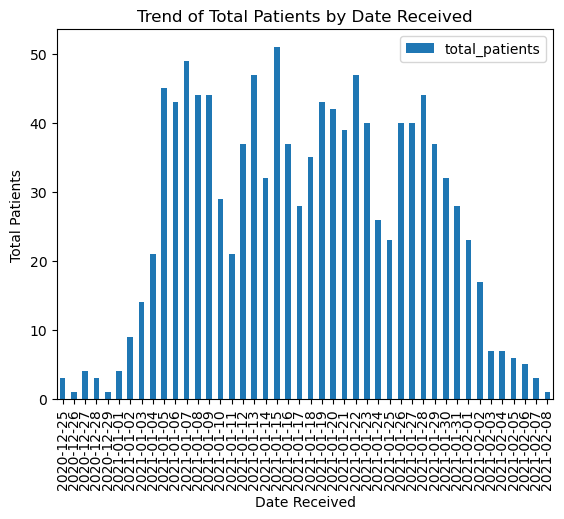

In [69]:
#Date - Trend in Chronological Order
from google.cloud import bigquery
import matplotlib.pyplot as plt

#Leveraged Python's GCP BigQuery library to pull distinct patient_id, date_received and use matplotlib to produce a bar chart

client = bigquery.Client()

query = '''
SELECT date_received, COUNT(DISTINCT patient_id) as total_patients
FROM healthverityproject.sampledataset5.healthverityproject_sampledataset5_sampledsetf
GROUP BY date_received
ORDER BY date_received;
'''

results = client.query(query).to_dataframe()

results.plot(x='date_received', y='total_patients', kind='bar')
plt.title("Trend of Total Patients by Date Received")
plt.xlabel("Date Received")
plt.ylabel("Total Patients")